In [18]:
import os
import tensorflow as tf
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

train_path = '../data/train'
test_path = '../data/original_test'
valid_path = '../data/val'
categories = ['NORMAL', 'PNEUMONIA']

img_size = 224

BATCH_SIZE = 10

In [19]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale=1/255.
).flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size),
    classes=categories,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale=1/255.
).flow_from_directory(
    directory=test_path,
    target_size=(img_size, img_size),
    classes=categories,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale=1/255.
).flow_from_directory(
    directory=valid_path,
    target_size=(img_size, img_size),
    classes=categories,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

for _set in ['train', 'val', 'original_test']:
    n_normal = len(os.listdir("../data/" + _set + '/NORMAL')) - 1
    n_infect = len(os.listdir("../data/" + _set + '/PNEUMONIA')) - 1
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(
        _set, n_normal, n_infect))
    
images, labels = next(train_batches)

model = Sequential()

# initialize the input_shape as (img_size, img_size) for the dimensions of our image and 3 for the channels
model.add(Conv2D(32, (3, 3),activation=('relu'),input_shape=(img_size,img_size,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation=('relu')))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(1,activation=('sigmoid')))

# we want to see how well our CNN will perform on the test data.
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', 'recall'])
hist = model.fit(test_batches, epochs=20, validation_data=valid_batches)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Set: train, normal images: 1340, pneumonia images: 3874
Set: val, normal images: 7, pneumonia images: 7
Set: original_test, normal images: 233, pneumonia images: 389
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.5796 - loss: 1.5632 - recall: 0.7254 - val_accuracy: 0.5000 - val_loss: 0.6901 - val_recall: 1.0000
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5539 - loss: 0.6708 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.3210 - val_recall: 1.0000
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.6157 - loss: 0.6821 - recall: 0.9421 - val_accuracy: 0.6250 - val_loss: 0.6970 - val_recall: 1.0000
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8062 - loss: 0.4411 - recall: 0.9162 - val_accuracy: 0.7500 - val_loss: 0.6072 - val_recall: 0.7500
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms

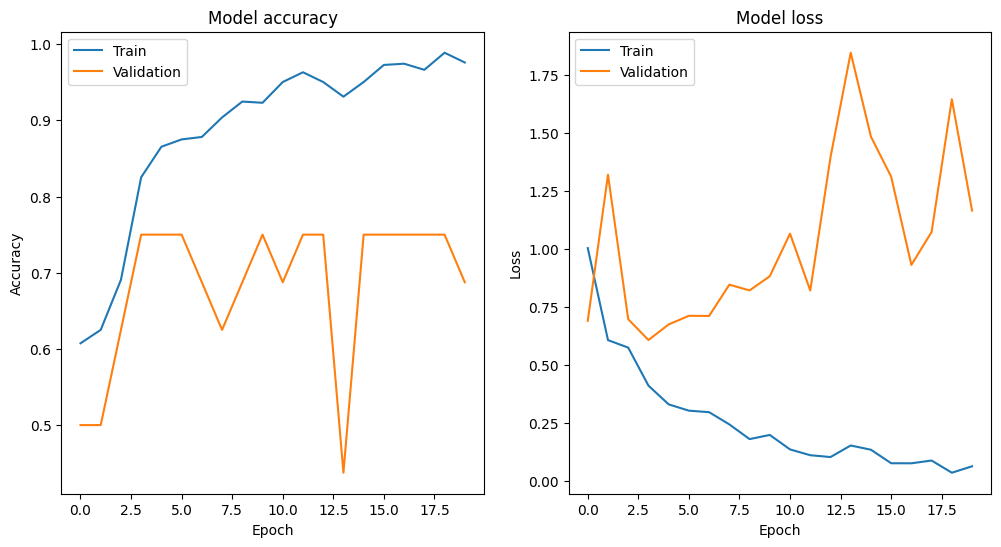

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       234
           1       1.00      0.99      1.00       390

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

[[234   0]
 [  2 388]]


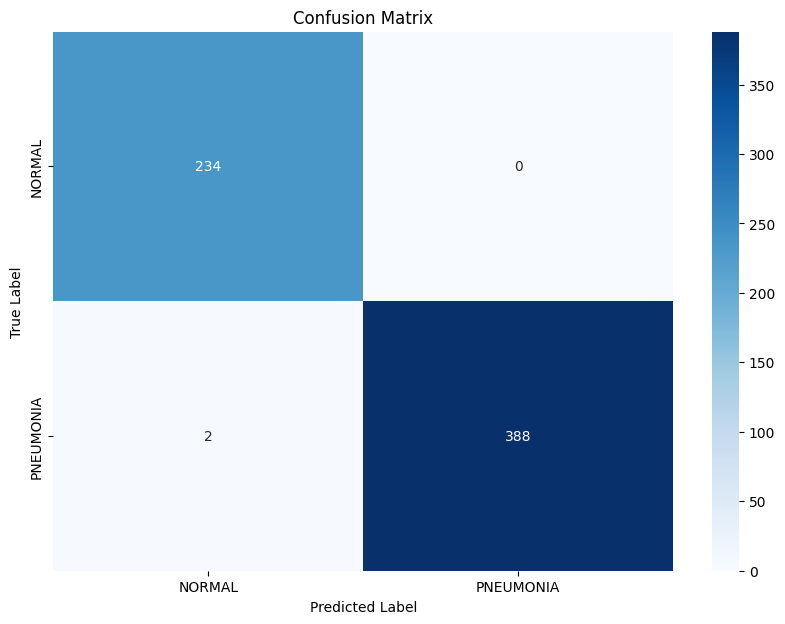

Test Accuracy: 0.9967948717948718
Test F1 Score: 0.9974293059125964
Test Recall: 0.9948717948717949
Test Precision: 1.0


In [20]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

y_test = test_batches.classes
Y_pred = model.predict(test_batches, steps=len(test_batches))
y_pred = (Y_pred > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Test F1 Score: {f1_score(y_test, y_pred)}")
print(f"Test Recall: {recall_score(y_test, y_pred)}")
print(f"Test Precision: {precision_score(y_test, y_pred)}")